In [2]:
%reload_ext autoreload
%autoreload 2

import os
from glob import glob

import numpy as np
import pandas as pd
from tqdm import tqdm

## Convert from NIfTI format to Numpy Arrays

In [ ]:
"""
    Convert all .nii.gz files to .npy arrays
"""

from monai.transforms import CropForegroundd, EnsureChannelFirstD, LoadImaged, Orientationd, Compose, \
    RandCropByPosNegLabeld

NIB_EXT = ".nii.gz"
DATA_DIR = "data/ATLAS_2/Training"
OUTPUT_SCAN_DIR = "data/ATLAS_2/Processed/Scans"
OUTPUT_MASK_DIR = "data/ATLAS_2/Processed/Masks"

os.makedirs(OUTPUT_SCAN_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

scans_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*_T1w" + NIB_EXT), recursive=True))
masks_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*T1lesion_mask" + NIB_EXT), recursive=True))

assert len(masks_filepaths) == len(scans_filepaths), "Length of masks and scans does not match"

# add channel dimension as the first axis, keep MRI orientation, crop the brain bounding box to exclude non-informative pixels
# images will be reshaped to (1, 192, 192, 189) - (C, H, W, D)
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstD(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    RandCropByPosNegLabeld(keys=["image", "label"], num_samples=1, spatial_size=(192, 192, -1), pos=1, neg=1,
                           label_key="label"),
])

for scan_filepath, mask_filepath in tqdm(zip(scans_filepaths, masks_filepaths),
                                         total=len(scans_filepaths), desc=f"Converting from {NIB_EXT} to .npy"):
    results = transforms({"image": scan_filepath, "label": mask_filepath})

    scan, mask = results[0]["image"], results[0]["label"]

    output_scan_filepath = scan_filepath.split("/")[-1].split(".")[0] + ".npy"
    output_mask_filepath = mask_filepath.split("/")[-1].split(".")[0] + ".npy"

    np.save(os.path.join(OUTPUT_SCAN_DIR, output_scan_filepath), scan)  # noqa
    np.save(os.path.join(OUTPUT_MASK_DIR, output_mask_filepath), mask)  # noqa


## Dataset Split (Parameter tuning)

We split the dataset into a 80-10-10 manner. This split will be used for hyperparameter tuning

Loading masks: 100%|██████████| 655/655 [00:35<00:00, 18.22it/s]
Getting lesion distribution metadata: 655it [00:21, 30.14it/s]


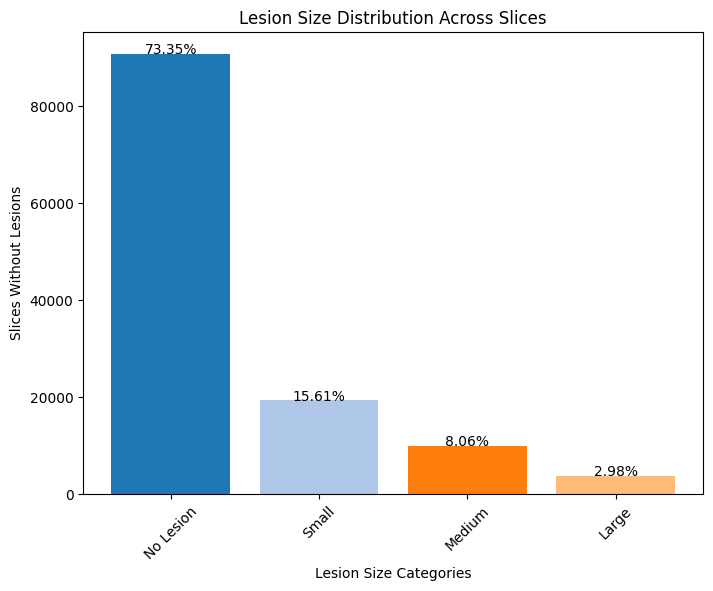

Loading masks: 100%|██████████| 545/545 [00:29<00:00, 18.30it/s]
Getting lesion distribution metadata: 545it [00:17, 31.22it/s]


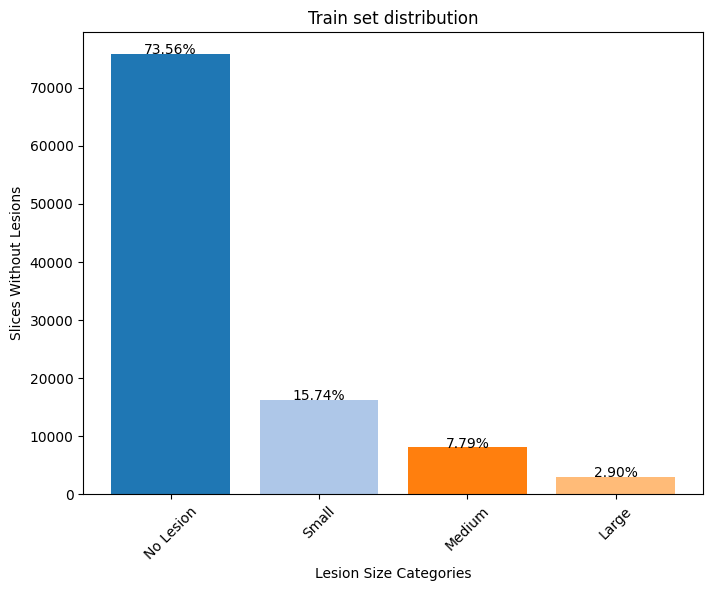

Loading masks: 100%|██████████| 68/68 [00:01<00:00, 34.31it/s]
Getting lesion distribution metadata: 68it [00:02, 32.94it/s]


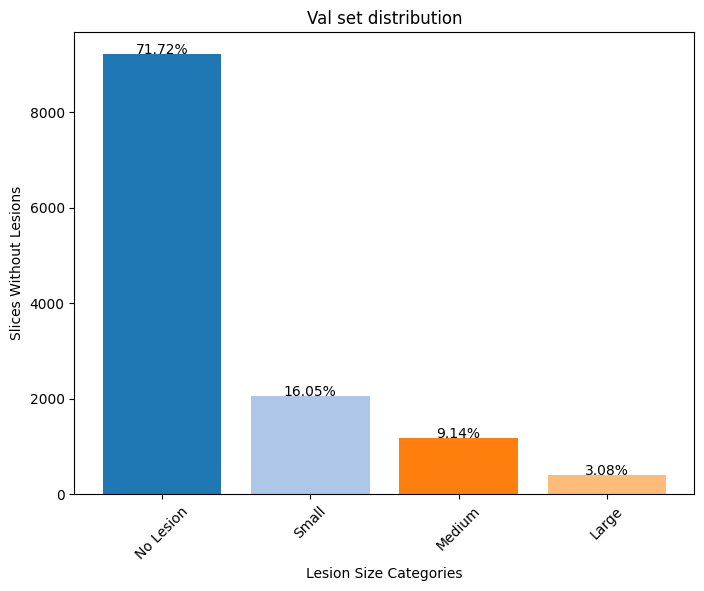

Loading masks: 100%|██████████| 42/42 [00:01<00:00, 33.37it/s]
Getting lesion distribution metadata: 42it [00:01, 32.44it/s]


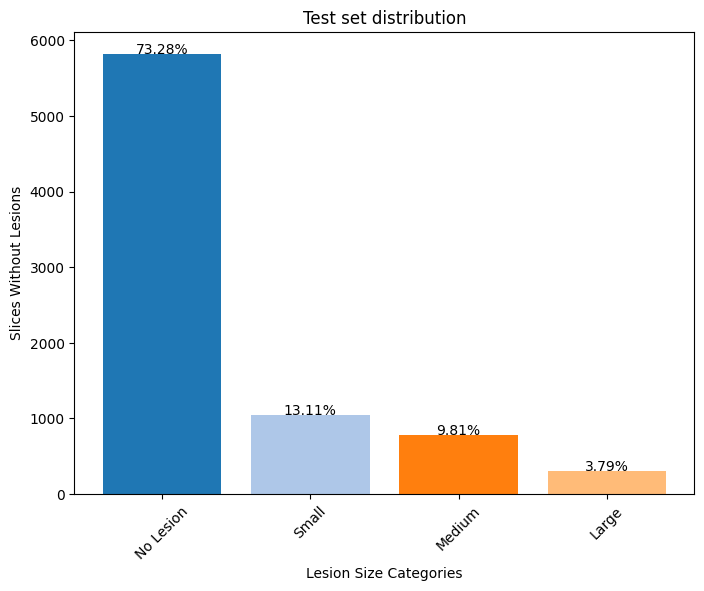

In [34]:
import os
from glob import glob

import pandas as pd

from utils import get_lesion_distribution_metadata, plot_lesion_size_distribution, plot_fold_distribution, round_half_up
from constants import LESION_SIZES

DEPTH = 189
SEED = 42
OUTPUT_MASK_DIR = "data/ATLAS_2/Processed/Masks"
masks_filepaths = sorted(glob(os.path.join(OUTPUT_MASK_DIR, "*T1lesion_mask.npy"), recursive=True))

metadata = get_lesion_distribution_metadata(masks_filepaths)
counts_across_slices = [metadata[size]["count"] for size in LESION_SIZES]

size_distributions = plot_lesion_size_distribution(counts_across_slices, LESION_SIZES, return_distribution=True)

dataframe_data = [{"size": size, "filepath": fp[0]} for size in LESION_SIZES for fp in metadata[size]["filepaths"]]
df = pd.DataFrame(dataframe_data)

# compute volume-level distribution
volume_dist = (
    df.groupby("filepath")["size"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# ensure 'filepath' is preserved
volume_dist.to_csv("volume_dist.csv")
volume_dist = pd.read_csv("volume_dist.csv")
os.remove("volume_dist.csv")

volume_dist = volume_dist.sample(frac=1, random_state=SEED)

total_slices = len(volume_dist) * DEPTH

assigned = set()
splits = {
    "train": {
        "percentage": 0.80,
        "indexes": [],
    },
    "val": {
        "percentage": 0.10,
        "indexes": [],
    },
    "test": {
        "percentage": 0.10,
        "indexes": [],
    }
}

for split in splits.keys():
    volumes_per_split =  round_half_up(total_slices * splits[split]["percentage"])
    fold_target = {k: volumes_per_split * v // 100 for k, v in size_distributions.items()}

    for filepath, row in volume_dist.iterrows():
        if filepath in assigned:
            continue

        contrib = {k: row.get(k, 0) * DEPTH for k in size_distributions.keys()}
        if any(v > 0 for v in fold_target.values()):
            splits[split]["indexes"].append(filepath)
            assigned.add(filepath)
            for k in fold_target.keys():
                
                fold_target[k] = max(0, fold_target[k] - contrib[k])

train_masks_paths = list(volume_dist.loc[splits["train"]["indexes"]].filepath)
val_masks_paths = list(volume_dist.loc[splits["val"]["indexes"]].filepath)
test_masks_paths = list(volume_dist.loc[splits["test"]["indexes"]].filepath)

plot_fold_distribution(train_masks_paths, title=f"Train set distribution")
plot_fold_distribution(val_masks_paths, title=f"Val set distribution")
plot_fold_distribution(test_masks_paths, title=f"Test set distribution")

In [42]:
import os
import shutil

from tqdm import tqdm

OUTPUT_DIR = "data/ATLAS_2/Processed/Splits/"
SPLITS = {
    "Train": train_masks_paths,
    "Val": val_masks_paths,
    "Test": test_masks_paths,
}

os.makedirs(OUTPUT_DIR, exist_ok=True)

for split, masks_filepaths in SPLITS.items():
    split_dir = os.path.join(OUTPUT_DIR, split)
    split_masks_dir = os.path.join(split_dir, "Masks")
    split_scans_dir = os.path.join(split_dir, "Scans")

    os.makedirs(split_masks_dir, exist_ok=True)
    os.makedirs(split_scans_dir, exist_ok=True)

    for mask_filepath in tqdm(masks_filepaths, desc=f"Creating {split} set"):
        scan_filepath = mask_filepath.replace("Masks", "Scans").replace("label-L_desc-T1lesion_mask", "T1w")

        shutil.copy(mask_filepath, os.path.join(split_masks_dir, mask_filepath.split(os.path.sep)[-1])) # noqa
        shutil.copy(scan_filepath, os.path.join(split_scans_dir, scan_filepath.split(os.path.sep)[-1])) # noqa

print(f"Train split: {len(train_masks_paths)}\nValidation split: {len(val_masks_paths)}\nTest split: {len(test_masks_paths)}")

Creating Test set: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]

Train split: 545
Validation split: 68
Test split: 42


## Augmentation: CarveMix + Ecological

In [ ]:
"""
    1. Find lesion and non-lesion slices that have closely head masks
    2. Refine the previous step to slices that have the most similar shape/size to lesion slices through IoU
    3. Calculate Structural Similarity Index (SSIM) to refine the previous step. Images with an high SSIM should have a similar vasculature structure
    4. Select the lesion and apply some morphological modification (e.g., contract, expand, rotate)
    5. Standardize intensities to smooth lesion integration
"""